## Laboratorium 7.1


## Metody wykrywania ruchu: przepływ optyczny (_optical flow_)

### Wstęp

Na poprzednich laboratoriach poznaliśmy podstawowe metody przetwarzania obrazów, a więc dwuwymiarowych sygnałów przestrzennych. Jednak w praktyce czasami dysponujemy materiałem wideo, a więc sygnałami _trójwymiarowymi_, gdzie trzecim wymiarem jest czas. Oczywiście, można takie dane traktować jako po prostu sekwencję niezależnych obrazów - i wtedy działają wszystkie poznane dotychczas metody. Jednak dlaczego by nie wykorzystać tej dziedziny czasowej do przetwarzania sygnału? Intuicyjnie czujemy, że jeśli jakiś rejon obrazu przesunął się w czasie, to prawdopodobnie ma on inne _znaczenie_ niż rejon, który pozostał w tym samym miejscu, lub przesunął w innym kierunku czy z inną szybkością. Jeśli zatem jesteśmy w stanie wykryć to przesunięcie - czyli po prostu _ruch_ - to otrzymamy pewną informację o zawartości obrazu (wideo). Na przykład, będziemy w stanie oddzielić poruszające się obiekty od stacjonarnego tła, albo oddzielić inaczej poruszające się obiekty.

Najpowszechniejszą metodą do automatycznej detekcji ruchu jest metoda przepływu optycznego (ang. _optical flow_). Pominiemy w tej instrukcji matematyczne podstawy tej metody - te są wystarczająco dobrze wyłożone w [artykule z dokumentacji OpenCV](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html), do którego lektury namawiam\*. Wiedzieć należy na pewno, że istnieją dwie główne odmiany metody przepływu optycznego:,
* przepływ gęsty (_dense_) - gdzie przesunięcie pomiędzy klatkami określane jest dla każdego piksela (na tej metodzie skupia się niniejsza część listy),
* przepływ rzadki (_sparse_) - gdzie ruch wykrywany jest tylko dla pewnego zbioru punktów zainteresowania w obrębie obrazu (przebadasz ją w drugiej części listy).

W ramach obu odmian występuje pewna liczba konkretnych metod obliczeniowych, w zależności od konkretnego podejścia do rozwiązywania równania ruchu. Na tych zajęciach wykorzystamy [algorytm Farnebacka](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) - głównie dlatego, że jego gotowa implementacja znajduje się w pakiecie OpenCV.

\* - Czytając, zwróć uwagę na podział na sekcje _Lucas-Kanade_ oraz _Dense Optical Flow_. Analizując kod metody, poświęć chwilę na zrozumienie mapowania wyników do prezentowanego obrazu w przestrzeni HSV.

### Podejście

Większość algorytmów optical flow operuje na parze klatek, znajdując translację pomiędzy jedną a drugą. Jeśli więc interesuje nas przetwarzanie ciągłego strumienia wideo, praca przebiegać będzie na zasadzie dwuelementowej kolejki, tzn. zawsze patrzymy na klatkę obecną i poprzednią.

OpenCV oferuje banalnie prosty a zarazem potężny interfejs do obsługi strumieni wideo: [`cv2.VideoCapture`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html), za pomocą którego w ten sam sposób możemy obsługiwać pliki wideo w różnym kodowaniu, urządzenia wideo (np. kamerkę w laptopie) czy nawet wideo w protokole IP (choć występują pewne różnice z punktu widzenia użycia, jeśli korzystamy z zasobu hardware'owego działającego w czasie rzeczywistym). Idea jest prosta:
* tworzymy obiekt `cv2.VideoCapture` w odpowiedni sposób,
* pobieramy poszczególne klatki za pomocą metody [`VideoCapture::read`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).

Metoda `read` wykonuje całą pracę (odczytanie danych, dekodowanie strumienia wideo) i zwraca klatkę jako obraz w standardowym formacie OpenCV (a także flagę, czy w ogóle udało się pozyskać dane - krotka (flaga, klatka)). Zatem, aby pozyskać pierwszą klatkę z pliku wideo wystarczy:
```python
vid = cv2.VideoCapture("back.mp4")
r, frame = vid.read()
```

Drobnym ograniczeniem VideoCapture jest to, że nie ma możliwości cofnięcia się do poprzednio pobranej klatki (co jest naturalne w przypadku korzystania z fizycznego urządzenia do akwizycji, a może trochę mniej gdy czytamy z pliku). Jeśli potrzebny jest powrót do początku pliku wideo, niestety konieczne jest zamknięcie strumienia (`VideoCapture::release`) i ponowne otwarcie (`::open`).

Aby obliczyć (gęsty) przepływ optyczny pomiędzy dwiema klatkami, wykorzystamy algorytm Farnebacka, zaimplementowany w OpenCV w funkcji [`cv2.calcOpticalFlowFarneback`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Przyjmuje ona parę obrazów **w skali szarości**, opcjonalny argument `flow` (rozwiązanie można zainicjować poprzednio wyliczonym przepływem, jeśli nim dysponujemy), a następnie szereg parametrów sterujących metodą; m.in. można wykorzystać piramidyzację obrazów (rekomendowane `pyr_size` $=3$) czy określić rozmiar okna detekcji `winsize`. Sensowne pierwsze wartości dla argumentów podane są w dokumentacji.

Algorytm Farnebacka zwraca przepływ w formie obrazu o wymiarach przestrzennych równych obrazom wejściowym i dwóch kanałach, zawierających przesunięcie odpowiednio w osi $x$ i $y$. Można więc przetwarzać te dane dalej, np. obliczając kąt przesunięcia czy całkowitą odległość (i dalej, np. określić prędkość ruchu) - vide np. `cv2.cartToPolar`.

---

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Zadanie 1

#### Zadanie 1a
Otwórz wideo `kick.mp4` lub `back.mp4` i pobierz kilka klatek. Przewiń do interesującego Cię momentu - tak, aby uzyskać dwie klatki, na których widać ruch (pro-tip: znając framerate materiału (~25fps) i czas, w którym rozpoczyna się interesujący fragment, możesz w pętli "skonsumować" odpowiednią ilość klatek).  
Wykorzystaj algorytm Farnebacka do obliczenia przepływu pomiędzy klatkami. Wynik zaprezentuj w postaci obrazu całkowitego przesunięcia. W zależności od wybranego momentu w wideo, możesz spodziewać się uzyskania wyraźnych obszarów.

In [2]:
def get_frames(video_path, second, frame_rate = 25, frame_in_second=0, n_frames=2):
    
    vid = cv2.VideoCapture(video_path)
    
    frames = []
    
    for _ in range(second*25+frame_in_second-1):
        r, frame = vid.read()
    
    for i in range(n_frames):
        r, frame = vid.read()
        frames.append(frame)
    
    vid.release()
    
    return frames

def plot_frames(images):
    f, (a1, a2) = plt.subplots(1, 2, figsize=(14,12))
    a1.imshow(images[0][..., ::-1]);
    a1.set_title('Frame 1')
    a2.imshow(images[1][..., ::-1]);
    a2.set_title('Frame 2')
    
def plot_flow(flow, winsize):
    f, (a1, a2) = plt.subplots(1, 2, figsize=(14,12))
    f.suptitle(f'Winsize {winsize}', fontsize=16)
    a1.imshow(flow[0]);
    a1.set_title('Magintude')
    a2.imshow(flow[1]);
    a2.set_title('Angle')


def run_flow(_frames, winsize=10):
    
    
    _frame_0_gray = cv2.cvtColor(_frames[0], cv2.COLOR_BGR2GRAY)
    _frame_1_gray = cv2.cvtColor(_frames[1], cv2.COLOR_BGR2GRAY)
    
    
    flow = cv2.calcOpticalFlowFarneback(
        _frame_0_gray, _frame_1_gray, flow = None, 
                pyr_scale=0.5, 
                levels=1, 
                winsize=winsize, 
                iterations=10,
                poly_n=5,
                poly_sigma=1.1,
                flags = None)
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    return mag, ang

[h264 @ 0x42b8f80] mmco: unref short failure
[h264 @ 0x42b8f80] mmco: unref short failure


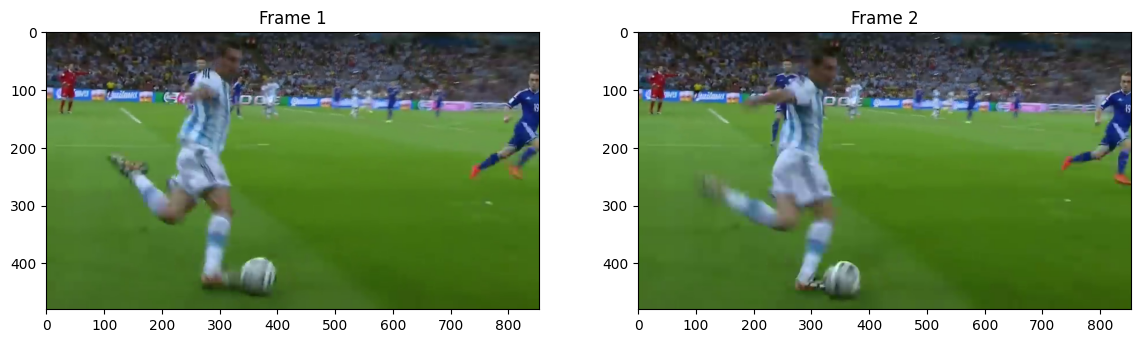

In [88]:
back_frames = get_frames("Data/back.mp4", 1, 2, 2)
plot_frames(back_frames)

[h264 @ 0x2a773c0] mmco: unref short failure
[h264 @ 0x2a773c0] mmco: unref short failure


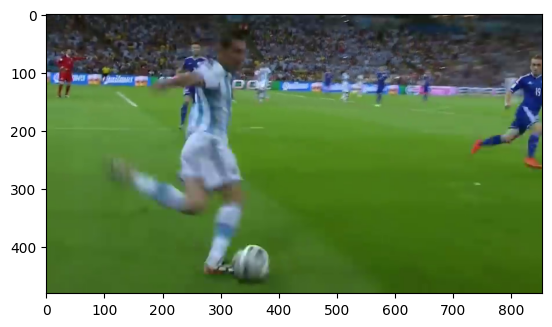

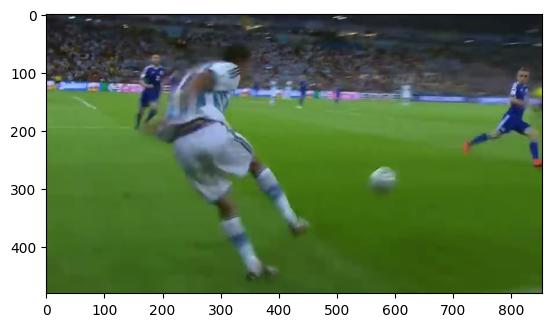

In [4]:
def skip_frames(video, seconds_to_skip, frame_rate):
    for _ in range(int(seconds_to_skip * frame_rate)):
        r, frame = video.read()
        if not r:
            break
    
    return video

def get_frames(filepath, start_frame_second, seconds_to_skip, frame_rate=25):
    vid = cv2.VideoCapture(filepath)
    vid = skip_frames(vid, start_frame_second, frame_rate)
    r, frame = vid.read()
    frames = [frame]
    vid = skip_frames(vid, seconds_to_skip, frame_rate)

    r, frame = vid.read()
    frames.append(frame)

    vid.release()

    return frames

frames = get_frames('Data/back.mp4', start_frame_second=1.1, seconds_to_skip=0.2, frame_rate=25)
plt.imshow(frames[0][..., ::-1])
plt.show()
plt.imshow(frames[1][..., ::-1])
plt.show()

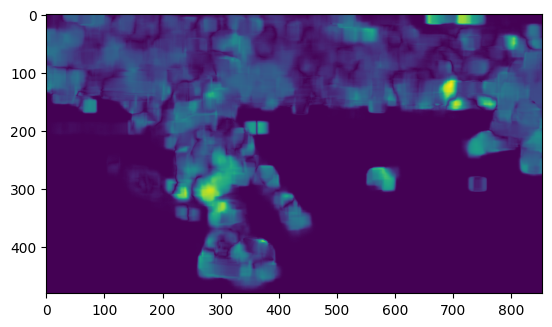

In [14]:
def calculate_optic_flow(frames, winsize=10):
    frame_0_gray = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
    frame_1_gray = cv2.cvtColor(frames[1], cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(
        frame_0_gray, frame_1_gray, flow = None,
        pyr_scale=0.5,
        levels=1,
        winsize=winsize,
        iterations=10,
        poly_n=5,
        poly_sigma=1.1,
        flags=None
    )

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1]) 

    return mag, ang

def plot_optic_flow(flow, ax=None):
    mag = flow[0]
    # mag, ang = flow
    # fig, (a1, a2) = plt.subplots(1, 2, figsize=(15, 10))
    # a1.imshow(mag)
    # a1.set_title('Magnitude')
    # a2.imshow(ang)
    # a2.set_title('Angle')

    if not ax:
        plt.imshow(mag)
    else:
        ax.imshow(mag)
    # hsv = np.zeros_like(frames[0])
    # hsv[..., 1] = 255
    # hsv[..., 0] = ang*180/np.pi/2
    # hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    # bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    # plt.imshow(bgr)
    # return hsv
    
flow = calculate_optic_flow(frames, winsize=20)
plot_optic_flow(flow)

#### Zadanie 1b
Zbadaj wpływ parametru `winsize` na działanie metody.

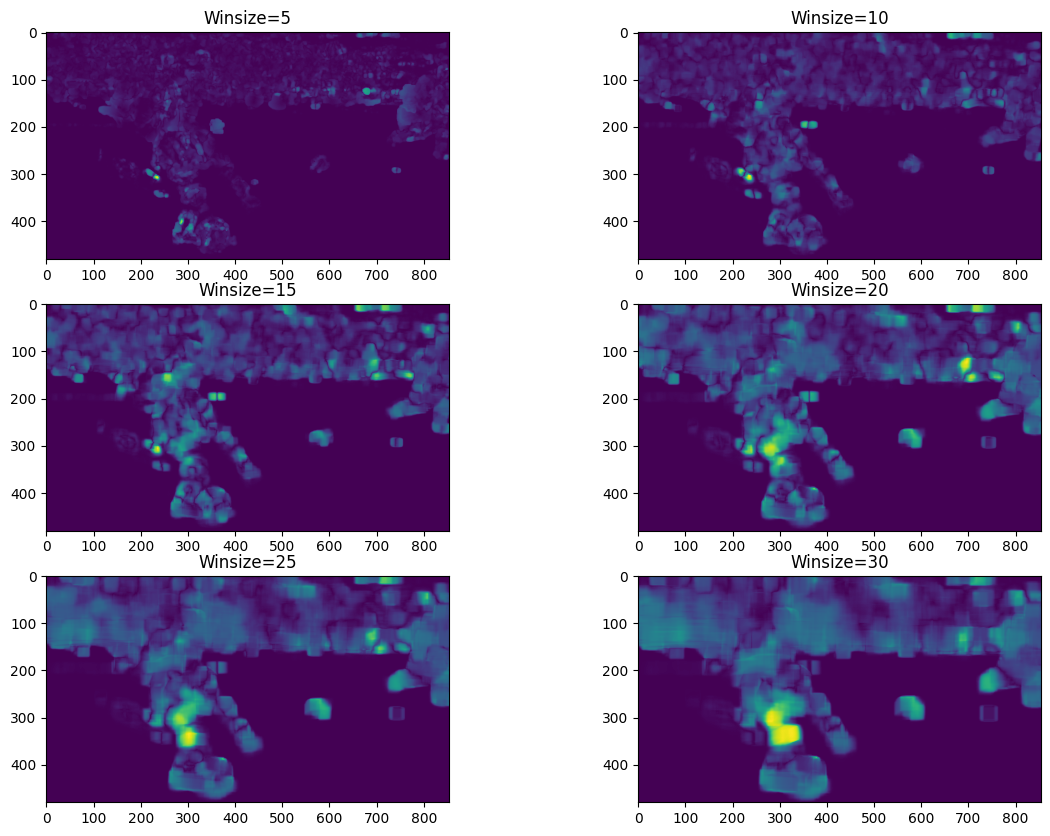

In [20]:
def make_winsize_experiment(frames, winsizes):
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    for ax, winsize in zip(axes.ravel(), winsizes):
        _ = plot_optic_flow(calculate_optic_flow(frames, winsize=winsize), ax=ax)
        ax.set_title(f'Winsize={winsize}')

winsizes = [5, 10, 15, 20, 25, 30]
make_winsize_experiment(frames, winsizes)

Komentarz 1:
Na obrazkach widać, że wykryta została zmiana w zmieniającym się, szczegółowym tle w obrazie.  
Wzrost winsize powoduje większe rozmycie oraz mniej precezyjny flow. 

---

### Zadanie 2

Powtórz powyższy eksperyment na materiale `shot.mp4` (przewiń materiał do momentu natychmiast po uderzeniu białej bili, ok. 20-25 klatek; framerate wynosi tu ok. 15fps).  
*W czym leży trudność? Co jest ograniczeniem metody?*

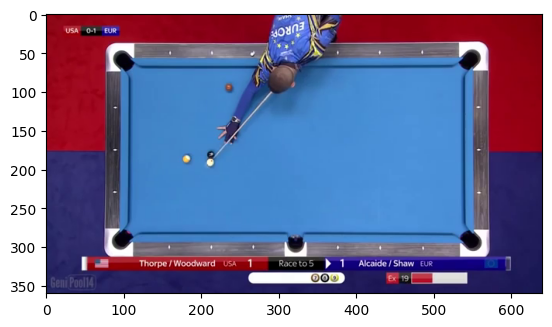

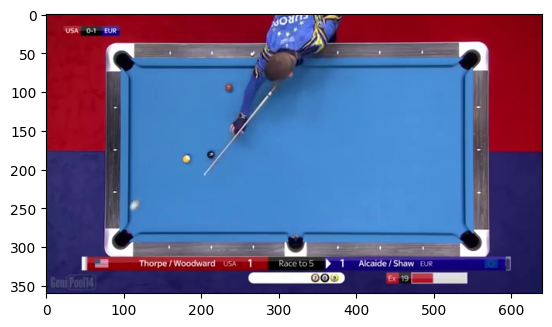

In [23]:
shot_frames = get_frames('Data/shot.mp4', 
    start_frame_second=20/15, 
    seconds_to_skip=0.2, frame_rate=15)
plt.imshow(shot_frames[0][..., ::-1])
plt.show()
plt.imshow(shot_frames[1][..., ::-1])
plt.show()


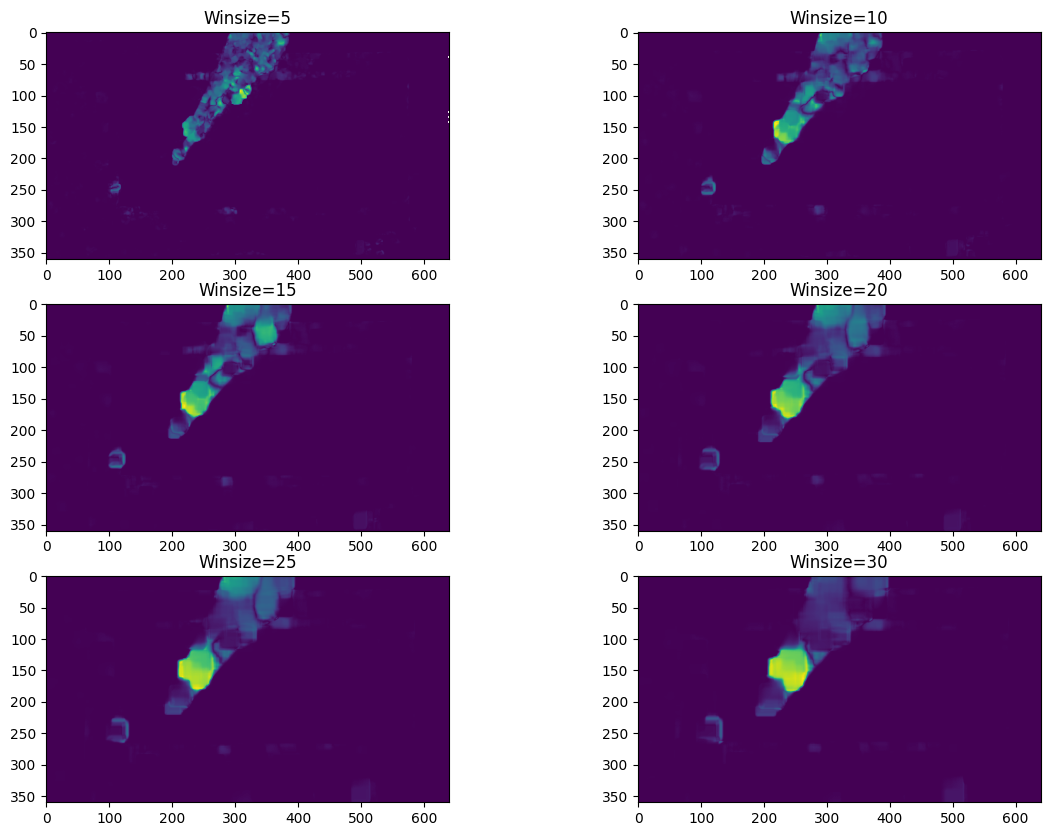

In [24]:
make_winsize_experiment(shot_frames, winsizes)

Komentarz 2:

### Zadanie 3

Powróć do takiego przypadku i konfiguracji algorytmu, dla którego uzyskane przez Ciebie wyniki były satysfakcjonujące. Przypomnij sobie zajęcia dotyczące np. segmentacji i wykorzystaj informację o przepływie optycznym do oddzielenia na obrazie obiektów od tła (metoda zupełnie dowolna).

[h264 @ 0x6a0d080] mmco: unref short failure
[h264 @ 0x6a0d080] mmco: unref short failure


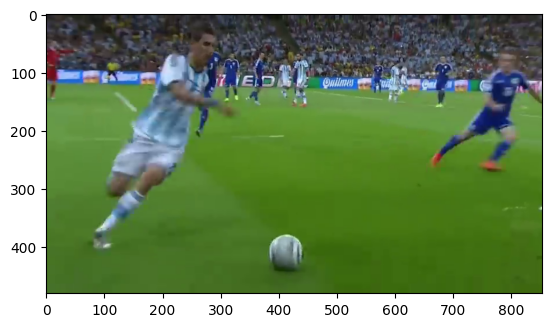

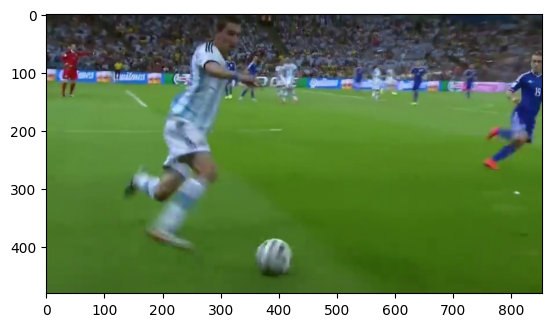

In [92]:
frames = get_frames('Data/back.mp4', start_frame_second=20/15, seconds_to_skip=0.2, frame_rate=15)
plt.imshow(frames[0][..., ::-1])
plt.show()
plt.imshow(frames[1][..., ::-1])
plt.show()


In [ ]:
flow = calculate_optic_flow(frames, winsize=20)
plot_flow(flow)


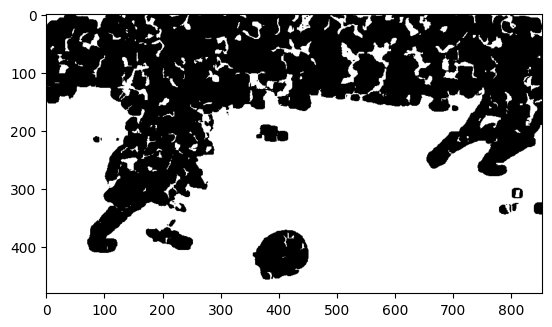

In [110]:
def separate_objects(flow):
    mag, ang = flow
    (T, img) = cv2.threshold(mag, 2, 255, cv2.THRESH_BINARY_INV)

    return img

mask = separate_objects(flow)

plt.imshow(mask, cmap='gray')